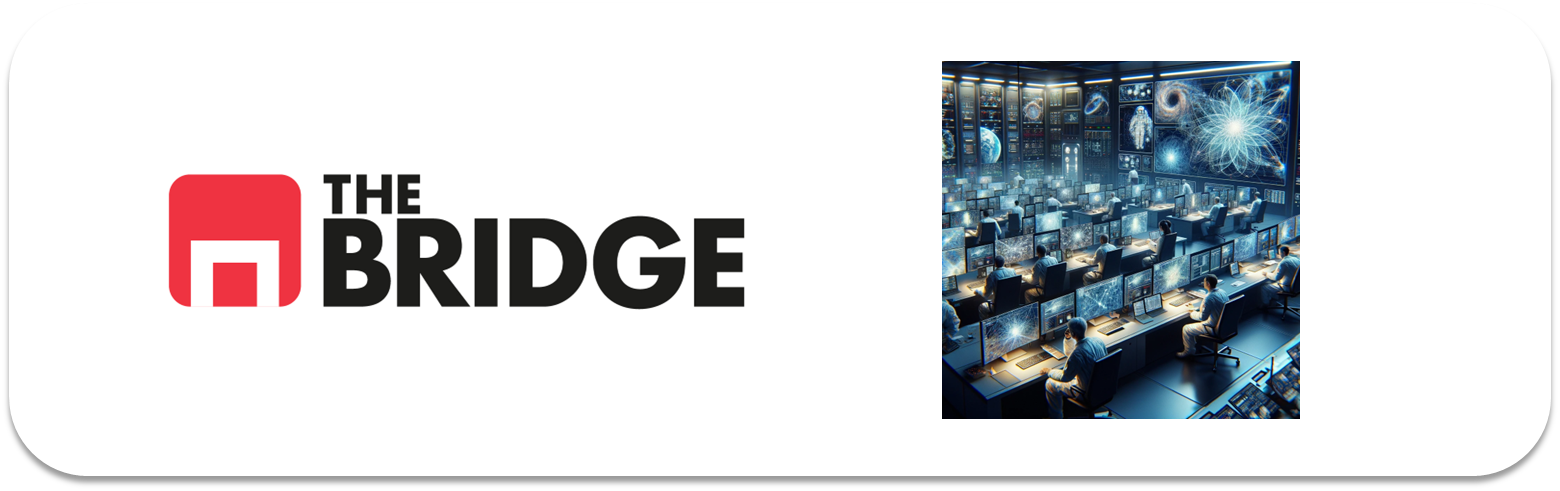

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras



from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions, preprocess_input


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



- Función para leer las imagenes y transformarlas en vectores o arrays de numpys. Se escoge dimension de 64x64 ya que las originales son de 150x150 y asi perder la menor información posible

In [2]:
def read_data(directorio, reshape_dim = (128,128)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [3]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + 'seg_train/'
TEST_PATH = ROOT_PATH + 'seg_test/'

In [4]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14034, 128, 128, 3)
(14034,)
(2971, 128, 128, 3)
(2971,)


- Visualización aleatoria de algunas imagenes

In [6]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

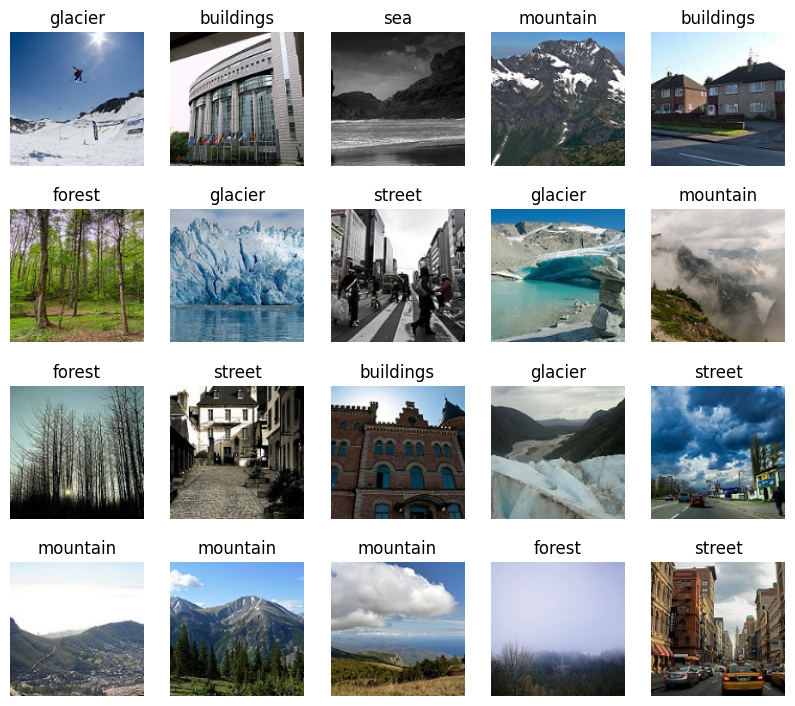

In [7]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

- Visualicemos como está repartido el target

In [8]:
target = pd.Series(y_train)
target.value_counts(True) * 100

mountain     17.899387
glacier      17.129828
street       16.973065
sea          16.203506
forest       16.182129
buildings    15.612085
Name: proportion, dtype: float64

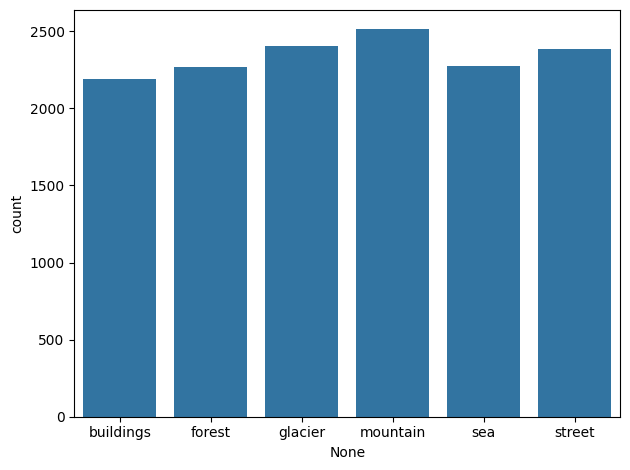

In [9]:
import seaborn as sns
sns.countplot(x = target)
plt.tight_layout()

- Escalado de las imágenes

In [10]:
X_train_32 = X_train.astype('float32')
X_test_32 = X_test.astype('float32')
X_train_s = preprocess_input(X_train_32)
X_test_s = preprocess_input(X_test_32)

In [12]:
print(X_train_s.min(), X_train_s.max())


-1.0 1.0


- Mezclamos los datos para que el modelo no reciba de manera seguida cada una de las clases

In [13]:
from sklearn.utils import shuffle
X_train_s, y_train = shuffle(X_train_s, y_train, random_state=42)

- Transformamos el target a numerico

In [14]:
dic = {}
n = 0
for x in target.unique():
    dic[x] = n
    n += 1

dic

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [15]:
dic_inverse = {}
for x,y in dic.items():
    dic_inverse[y] = x

dic_inverse

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [16]:
y_train_num = np.array([dic[cat] for cat in y_train])
y_test_num = np.array([dic[cat] for cat in y_test])

In [17]:
np.unique(y_train_num)

array([0, 1, 2, 3, 4, 5])

- Cargamos la red escogida por recomendación por potencia de ordenador: MobileNetV2

In [18]:
base_model = MobileNetV2(input_shape=(128, 128,3),
                        include_top=False, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights= 'imagenet')

- Empleamos el bucle para que no entrene el modelo entero de nuevo, si no a partir de las cabezas de transfer learning

In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(6, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model.input, x)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

- Vamos a entrenar el modelo

In [21]:
from keras.callbacks import EarlyStopping
earlyS = keras.callbacks.EarlyStopping(patience= 5, restore_best_weights= True)

In [22]:
history  = model.fit(X_train_s, y_train_num, batch_size=64, epochs=20, callbacks=[earlyS], validation_split=0.2)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 123s 636ms/step - accuracy: 0.7165 - loss: 1.2528 - val_accuracy: 0.9145 - val_loss: 0.2654
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 583ms/step - accuracy: 0.8566 - loss: 0.4637 - val_accuracy: 0.9156 - val_loss: 0.2506
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 532ms/step - accuracy: 0.8824 - loss: 0.3725 - val_accuracy: 0.9213 - val_loss: 0.2510
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 525ms/step - accuracy: 0.9081 - loss: 0.2871 - val_accuracy: 0.9248 - val_loss: 0.2281
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 91s 519ms/step - accuracy: 0.9036 - loss: 0.2736 - val_accuracy: 0.9209 - val_loss: 0.2380
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 90s 514ms/step - accuracy: 0.9322 - loss: 0.2119 - val_accuracy: 0.9266 - val_loss: 0.2268
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 90s 510ms/step - accuracy: 0.9284 - loss: 0.2257 - val_accuracy: 0.9259 - val_loss: 0.2362
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 90s 512ms/step - accuracy: 0.9419 - loss:

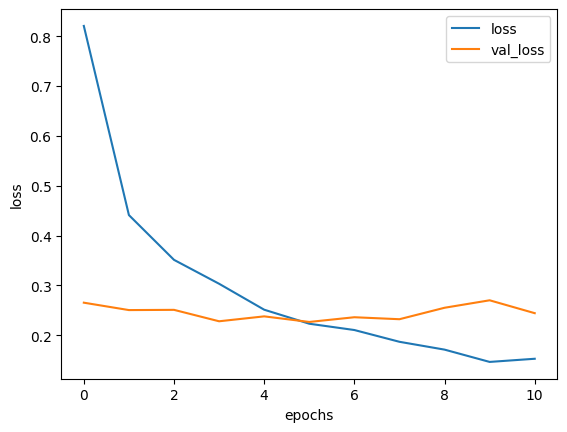

In [23]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

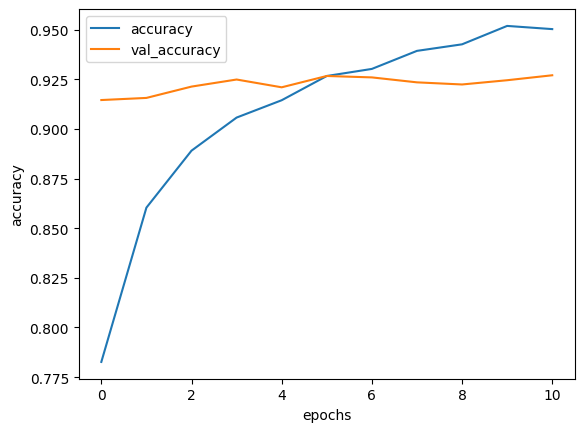

In [24]:
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

In [25]:
def evaluar_fine_tuning(history):
    import numpy as np

    acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    print(f"📊 accuracy:     {acc:.4f}")
    print(f"📊 val_accuracy: {val_acc:.4f}")
    print(f"📉 loss:         {loss:.4f}")
    print(f"📉 val_loss:     {val_loss:.4f}")
    print()

    recomendaciones = []

    if val_acc < acc - 0.05:
        recomendaciones.append("⚠️ Hay sobreajuste: `val_accuracy` significativamente menor que `accuracy`.")
    
    if val_loss > loss * 1.5:
        recomendaciones.append("⚠️ `val_loss` es mucho mayor que `loss`, posible desajuste en la confianza del modelo.")

    if acc < 0.90:
        recomendaciones.append("ℹ️ `accuracy` < 90% → el modelo aún tiene margen de mejora.")

    if val_acc < 0.90:
        recomendaciones.append("ℹ️ `val_accuracy` < 90% → podrías afinar capas del modelo base.")

    if not recomendaciones:
        recomendaciones.append("✅ El modelo ya generaliza bien. Fine-tuning no es necesario, pero puedes intentarlo para mejorar un poco más.")

    print("📌 Recomendación:")
    for r in recomendaciones:
        print(" ", r)

In [26]:
evaluar_fine_tuning(history)

📊 accuracy:     0.9502
📊 val_accuracy: 0.9270
📉 loss:         0.1529
📉 val_loss:     0.2444

📌 Recomendación:
  ⚠️ `val_loss` es mucho mayor que `loss`, posible desajuste en la confianza del modelo.


In [27]:
model.evaluate(X_test_s,y_test_num)

93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.9264 - loss: 0.2070


[0.23578795790672302, 0.9215752482414246]

In [31]:
from sklearn.metrics import classification_report
y_pred = [dic_inverse[np.argmax(prediction)] for prediction in  model.predict(X_test_s)]


print(classification_report(y_test,y_pred))

93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step
              precision    recall  f1-score   support

   buildings       0.90      0.93      0.92       408
      forest       0.99      0.99      0.99       474
     glacier       0.90      0.84      0.87       553
    mountain       0.86      0.91      0.88       525
         sea       0.95      0.95      0.95       510
      street       0.94      0.92      0.93       501

    accuracy                           0.92      2971
   macro avg       0.92      0.92      0.92      2971
weighted avg       0.92      0.92      0.92      2971



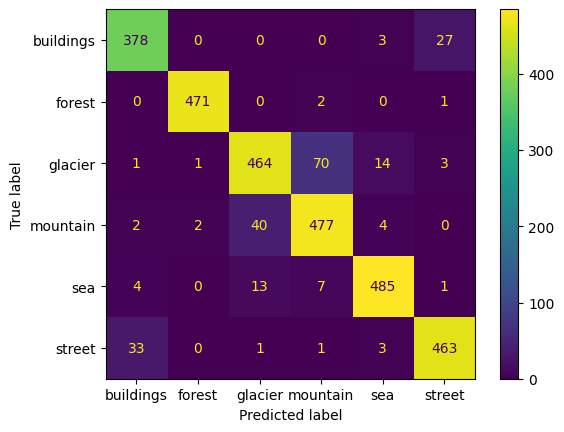

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

- Fine-tuning. No es necesaario realizar fine tuning ya que las metricas no indican sobreajuste y generalizan bien


In [34]:
from tensorflow.keras.optimizers import Adam


base_model.trainable = True

fine_tune_at = 30       # Elegimos desde qué capa empezar a afinar (por ejemplo, desde la capa 30)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


x = layers.Flatten()(base_model.output)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(6, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])



early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_fine = model.fit(
    X_train_s, y_train_num,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 98s 519ms/step - accuracy: 0.3279 - loss: 2.2366 - val_accuracy: 0.8579 - val_loss: 0.5845
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 476ms/step - accuracy: 0.6377 - loss: 0.9840 - val_accuracy: 0.8910 - val_loss: 0.3734
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 467ms/step - accuracy: 0.7435 - loss: 0.6980 - val_accuracy: 0.8995 - val_loss: 0.3125
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 467ms/step - accuracy: 0.7975 - loss: 0.5837 - val_accuracy: 0.9067 - val_loss: 0.2863
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 466ms/step - accuracy: 0.8135 - loss: 0.5235 - val_accuracy: 0.9116 - val_loss: 0.2667
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 465ms/step - accuracy: 0.8283 - loss: 0.4816 - val_accuracy: 0.9166 - val_loss: 0.2565
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 472ms/step - accuracy: 0.8567 - loss: 0.4200 - val_accuracy: 0.9156 - val_loss: 0.2520
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 495ms/step - accuracy: 0.8560 - loss: 0

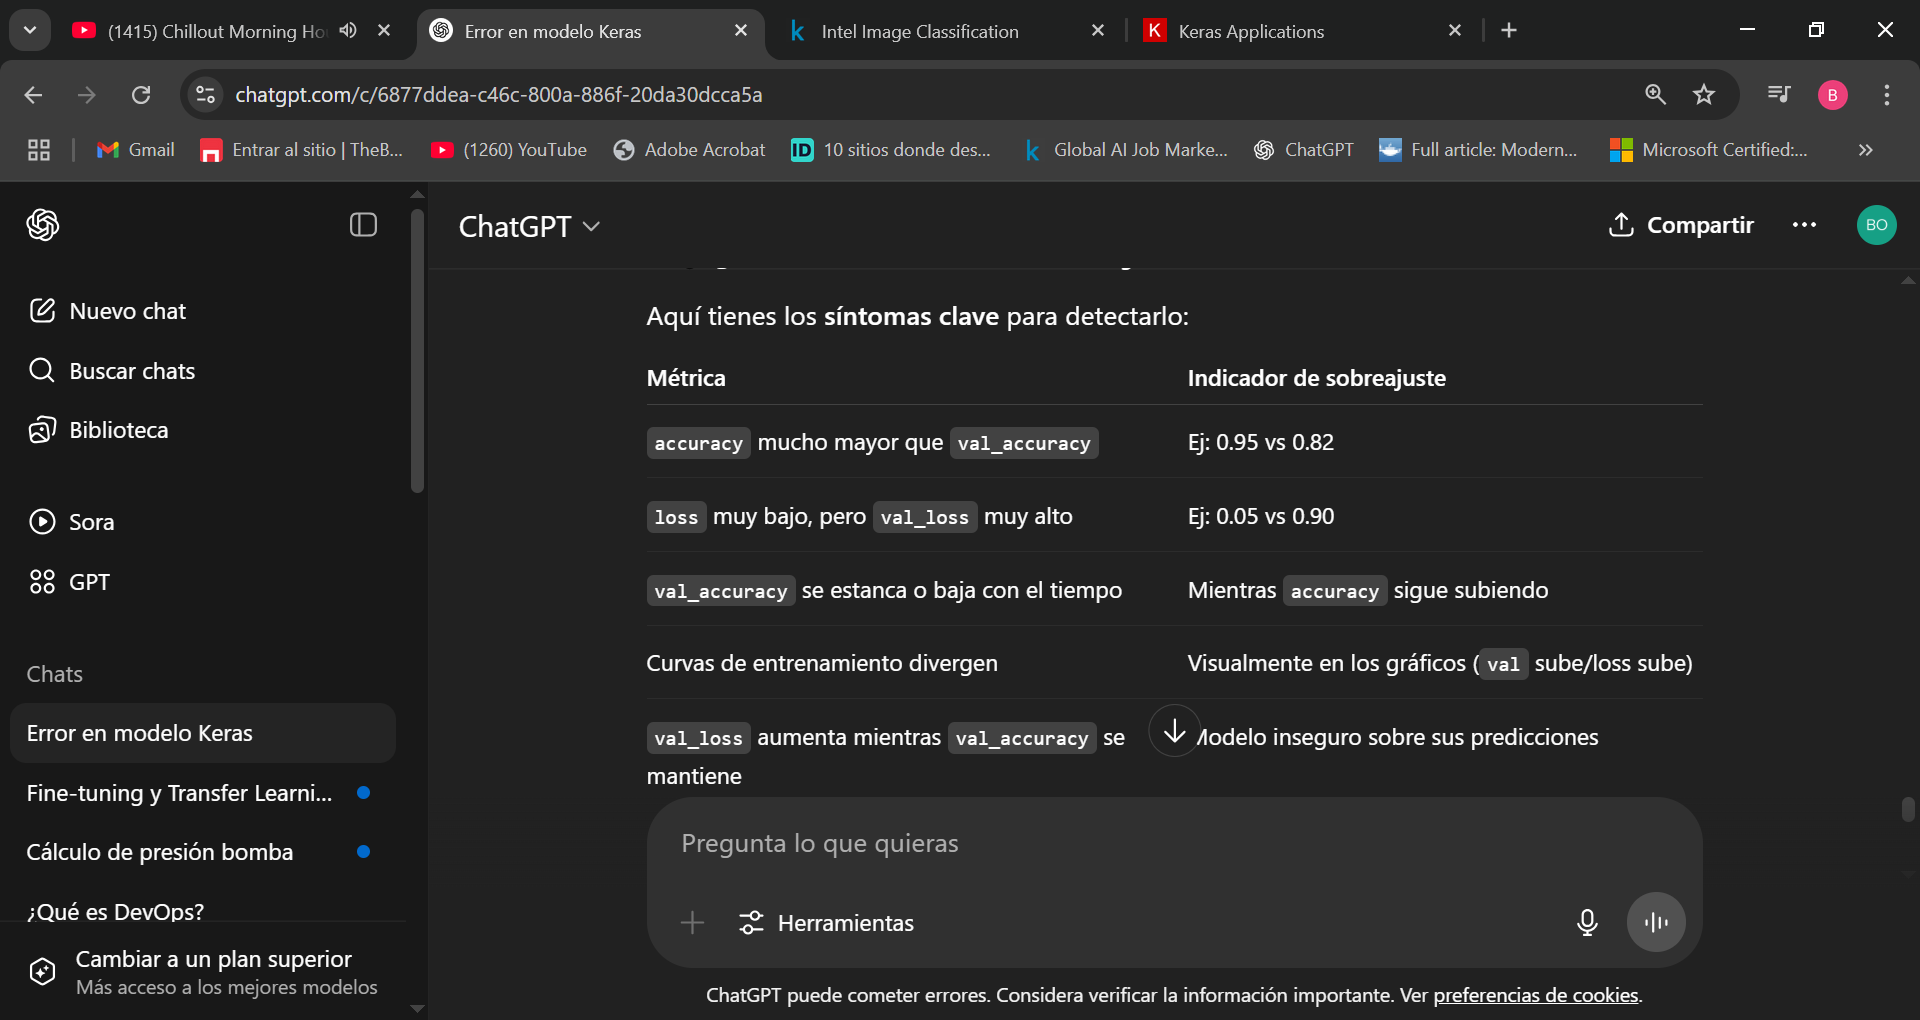

No mejora. Vamos a probar con un preprocess_input para darle al modelo el formato que necesita a ver si está aquí el problema